In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
#import lightgbm as lgb

The following code will help to throw away all HTML tags from article content/title.

In [3]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [4]:
PATH_TO_DATA = './data'

Supplementary function to read a JSON line without crashing on escape characters.

In [5]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

This function takes a JSON and forms a txt file leaving only article titles. When you resort to feature engineering and extract various features from articles, a good idea is to modify this function.

In [6]:
def extract_titles_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            content = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            out_file.write(content_no_html_tags + '\n')

In [7]:
%%time
extract_titles_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_titles.txt', total_length=62313)


CPU times: user 13.1 s, sys: 880 ms, total: 14 s
Wall time: 14 s


In [8]:
%%time
extract_titles_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_titles.txt', total_length=34645)


CPU times: user 7.34 s, sys: 466 ms, total: 7.8 s
Wall time: 7.8 s


## Feature engineering (simple Tf-Idf for titles)¶
We'll use a very simple feature extractor – TfidfVectorizer, meaning that we resort to the Bag-of-Words approach. For now, we are leaving only 50k features.

In [9]:
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 3))

In [10]:
%%time
with open('train_titles.txt', encoding='utf-8') as input_train_file:
    X_train = tfidf.fit_transform(input_train_file)

CPU times: user 4.3 s, sys: 153 ms, total: 4.45 s
Wall time: 3.42 s


In [11]:
%%time
with open('test_titles.txt', encoding='utf-8') as input_test_file:
    X_test = tfidf.transform(input_test_file)

CPU times: user 703 ms, sys: 5.97 ms, total: 709 ms
Wall time: 709 ms


In [12]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

Read targets from a file

In [13]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                        'train_log1p_recommends.csv'), 
                           index_col='id')

In [14]:
y_train = train_target['log_recommends'].values

Target is still somewhat skewed, though it's allready log1p-transformed (#claps with log1p transformation). Yet, we'll apply log1p once more time.

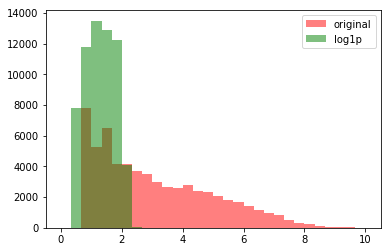

In [15]:
plt.hist(y_train, bins=30, alpha=.5, color='red', 
         label='original', range=(0,10));
plt.hist(np.log1p(y_train), bins=30, alpha=.5, color='green', 
         label='log1p', range=(0,10));
plt.legend();

## Validation and model training
Let's make a 30%-holdout set.

In [16]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

Now we are ready to fit a linear model.

In [17]:
ridge = Ridge(random_state=17)

In [18]:
%%time
ridge.fit(X_train_part, np.log1p(y_train_part));

CPU times: user 1.33 s, sys: 4.92 ms, total: 1.34 s
Wall time: 404 ms


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

After log1p-transformation, we need to apply an inverse  expm1-trasformation to predictions.

In [19]:
ridge_pred = np.expm1(ridge.predict(X_valid))

Then, we fit a LightGBM model with mean_absolute_error as objective (it's important!).

In [21]:
# lgb_x_train_part = lgb.Dataset(X_train_part.astype(np.float32), label=np.log1p(y_train_part))

In [22]:
# lgb_x_valid = lgb.Dataset(X_valid.astype(np.float32), label=np.log1p(y_valid))

In [24]:
#param = {'num_leaves': 255, 
#         'objective': 'mean_absolute_error',
#         'metric': 'mae'}

In [25]:
# num_round = 200
# bst_lgb = lgb.train(param, lgb_x_train_part, num_round, valid_sets=[lgb_x_valid], early_stopping_rounds=20)

In [ ]:
# lgb_pred = np.expm1(bst_lgb.predict(X_valid.astype(np.float32), num_iteration=bst_lgb.best_iteration))

Let's plot predictions and targets for the holdout set. Recall that these are #recommendations (= #claps) of Medium articles with the  np.log1p transformation.

In [26]:
#plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
#plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
#plt.hist(lgb_pred, bins=30, alpha=.5, color='blue', label='Lgbm', range=(0,10));
#plt.legend();

As we can see, the prediction is far from perfect, and we get MAE  ≈  1.3 that corresponds to  ≈  2.7 error in #recommendations.

In [27]:
ridge_valid_mae = mean_absolute_error(y_valid, ridge_pred)
ridge_valid_mae

1.2521077393066944

In [28]:
# lgb_valid_mae = mean_absolute_error(y_valid, lgb_pred)
# lgb_valid_mae

## Simple blending
Now let's mix predictions. We's just pick up weights 0.6 for Lgbm and 0.4 for Ridge, but these are typically tuned via cross-validation.

In [29]:
# mean_absolute_error(y_valid, .4 * lgb_pred + .6 * ridge_pred)

Finally, train both models on the full accessible training set, make predictions for the test set and form submission files.

In [30]:
%%time
ridge.fit(X_train, np.log1p(y_train));

CPU times: user 1.61 s, sys: 7.99 ms, total: 1.62 s
Wall time: 684 ms


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [31]:
%%time
ridge_test_pred = np.expm1(ridge.predict(X_test))

CPU times: user 15.2 ms, sys: 651 µs, total: 15.8 ms
Wall time: 5.94 ms


In [32]:
#lgb_x_train = lgb.Dataset(X_train.astype(np.float32), label=np.log1p(y_train))

In [33]:
#num_round = 60
#bst_lgb = lgb.train(param, lgb_x_train, num_round)

In [34]:
#lgb_test_pred = np.expm1(bst_lgb.predict(X_test.astype(np.float32)))

Here's a simple mix

In [35]:
# mix_pred = .4 * lgb_test_pred + .6 * ridge_test_pred

### Leaderboard probing
Now we apply a dirty hack. Originally, we made you come up with it by your own (as a part of an assignment, with only a hint from out side), but now it's described in this tutorial, written within a previous session of mlcourse.ai.

Submitting all zeros gives 4.33328. If you take a pen and a piece of paper and figure out what it means for MAE that all predictions are zeros, then you'll see that it's exactly the mean target value for the test set. We can compare it with mean target for training data and correspondingly adjust predictions. Looks like a dirty hack, however, the same thing is often done with time series prediction (even in production) - merely adjusting your predictions to a change in target variable distribution.

In [41]:
mean_test_target = 4.33328

In [44]:
# mix_test_pred_modif = mix_pred + mean_test_target - y_train.mean()
#mix_test_pred_modif = ridge_test_pred + mean_test_target - y_train.mean()

In [36]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [40]:
#write_submission_file(ridge_test_pred, 'submissions/03-medium-submission.csv') # 2.03034 # no probing

In [46]:
# 1.65253
write_submission_file(ridge_test_pred + mean_test_target - y_train.mean(), 'submissions/03-ridge_submission.csv')

In [ ]:
#write_submission_file(lgb_test_pred + mean_test_target - y_train.mean(), 'submissions/03-lgb_submission.csv')

In [43]:
#write_submission_file(mix_test_pred_modif, 'submissions/03-medium-submission-probing.csv')

As we can see, simple blending decreases MAE for both holdout predictions and on the leaderboard. However, I don't recommend to play with blending/stacking schemes un the beginning of the competition – it's crucially important to come up with good features first.

You can further improve your model in various ways. I've described them in this kernel. Go and compete, good luck! https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline

### TODO look at the leaderboard probing

### TODO implement this part from https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-blending-hacking